<a href="https://colab.research.google.com/github/shinnew9/cse347-cse447RL/blob/main/lab2_mdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Markov Decision Problems

# Exercise 1: Grid World
Compute the value funnction for the example 4.1 in the book.







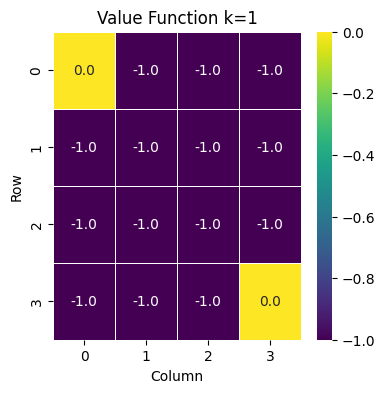

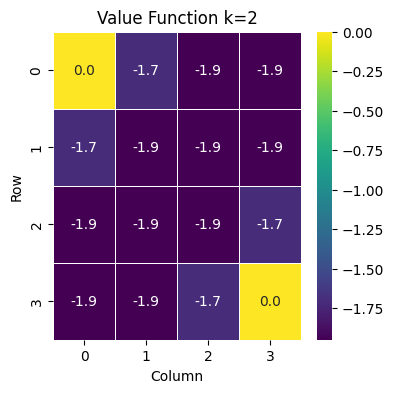

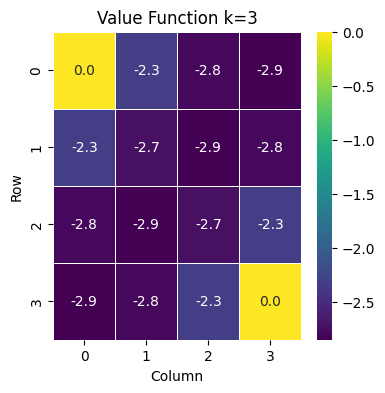

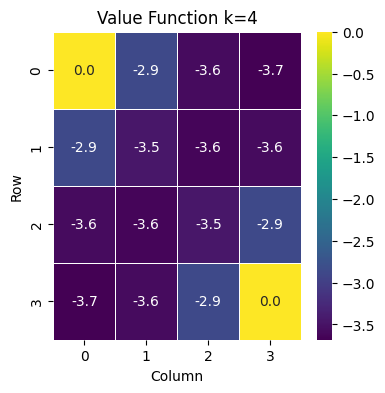

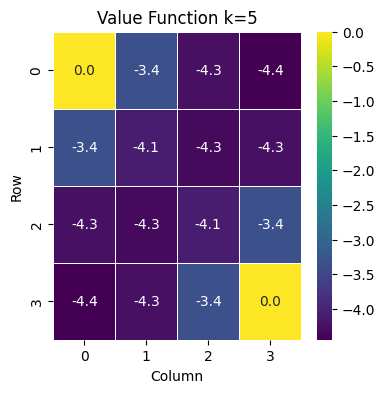

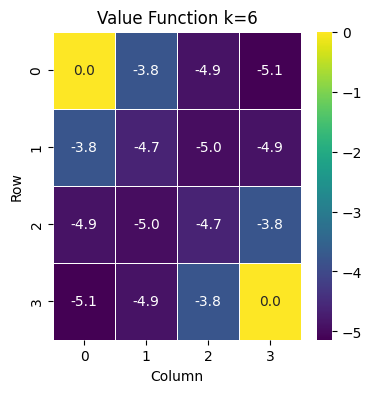

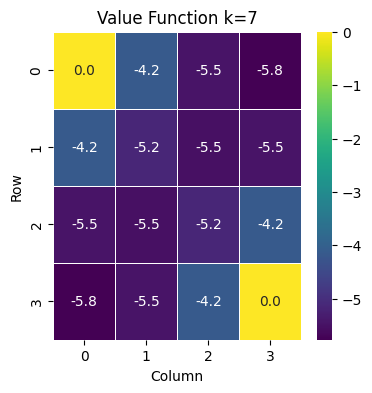

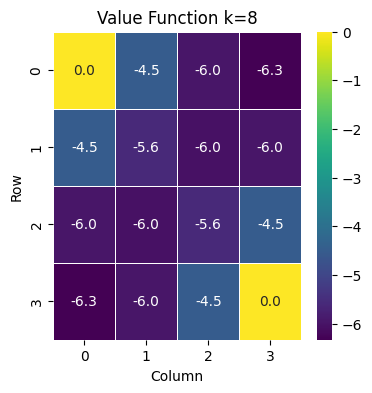

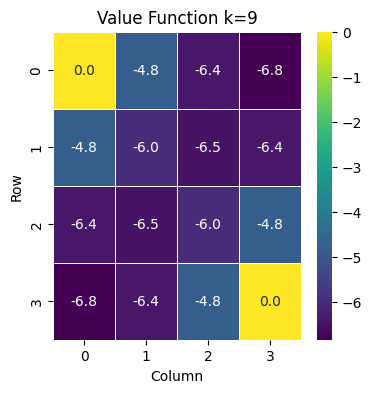

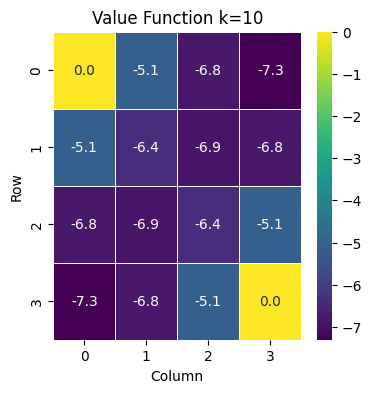

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


V = np.zeros(16)
gamma = 0.95  # Discount factor
V_old = np.zeros(16)


# state index <-> (row, col)
def idx2rc(s, n=4):
  return divmod(s,n)  # (row, col)

def rc2idx(r, c, n=4):
  return r*n +c


# Action Function (U, D, L, R)
ACTIONS = [(-1,0), (1,0), (0,-1), (0,1)]

for k in range(10):
  for s in range(16):

    if s==0 or s==15:
      continue

   #### Write your code here #########
    # Bellman expectation backup under uniform random policy:
    # V(s) = sum_a pi(a|s) * [r+gamma *V_old(s')]
    v_new = 0.0
    for dr, dc in ACTIONS:
      r, c = idx2rc(s, 4)  # 현재 위치 (row, col)
      nr, nc = r + dr, c + dc   # dr, dc는 행동 때문에 생기는 변화량


      # 격자 밖 -> 제자리
      if not (0<=nr < 4 and 0<=nc<4):  # if both row and col are under 3,
        ns = s
      else:
        ns = rc2idx(nr, nc, 4)

      reward = -1.0
      v_new += 0.25 * (reward + gamma * V_old[ns])
    V[s] = v_new
    # ------------------------------------------------
  V_old = V.copy()


  ###### PLOT
  # Reshape the 1D value function array into an 8x8 grid
  V_grid = V.reshape((4, 4))

  # Plot the value function as a heatmap
  plt.figure(figsize=(4, 4))
  sns.heatmap(V_grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5)
  plt.title("Value Function k=%d"%(k+1))
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.show()

# Exercise 2: Grid World
Compute the optimal policy




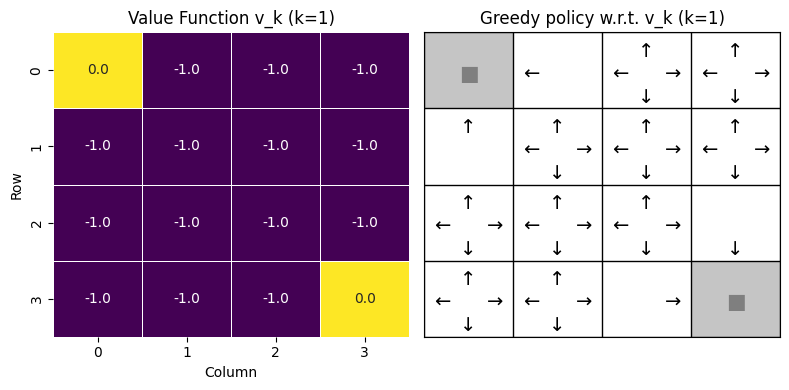

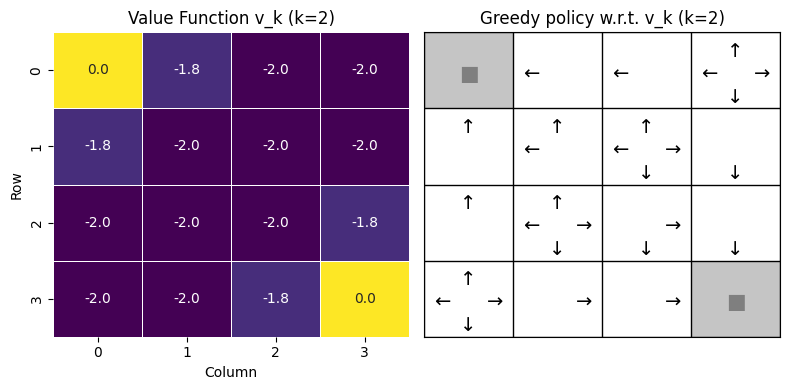

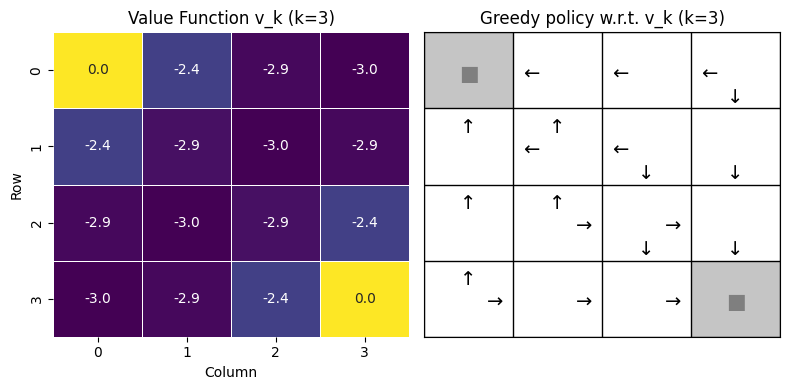

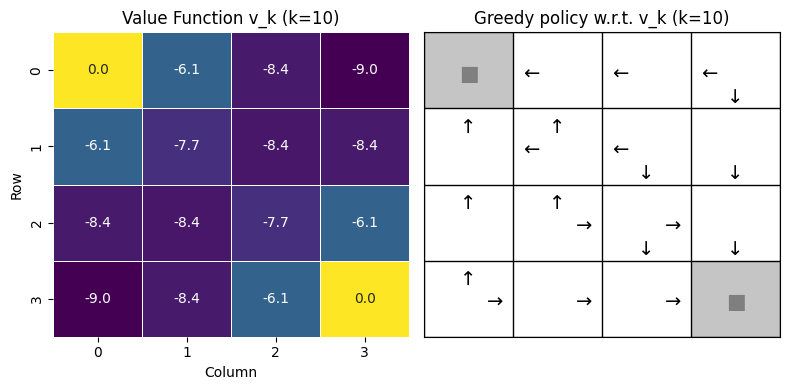

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Grid & MDP settings ----
n = 4
S = n*n
gamma = 1.0
reward = -1.0
TERMINALS = {0, S-1}
ACTIONS = [(-1,0),(1,0),(0,-1),(0,1)]  # U, D, L, R

def idx2rc(s): return divmod(s, n)
def rc2idx(r,c): return r*n + c

def step(s, dr, dc):
    if s in TERMINALS:
        return s, 0.0
    r, c = idx2rc(s)
    nr, nc = r+dr, c+dc
    if not (0 <= nr < n and 0 <= nc < n):
        ns = s
    else:
        ns = rc2idx(nr, nc)
    return ns, reward

# ---- Value Iteration snapshots ----
V = np.zeros(S)
snapshots = {0: V.copy()}
K = 10
for k in range(1, K+1):
    V_old = V.copy()
    for s in range(S):
        if s in TERMINALS:
            V[s] = 0.0
            continue
        v_new = 0.0
        for dr, dc in ACTIONS:
            ns, r = step(s, dr, dc)
            v_new += 0.25 * (r + gamma * V_old[ns])  # equiprobable random policy
        V[s] = v_new
    snapshots[k] = V.copy()

# ---- Plot value + policy side by side ----
ARROW_TXT = {(-1,0):'↑',(1,0):'↓',(0,-1):'←',(0,1):'→','T':'■'}

def greedy_actions_with_ties(Vk, s, tol=1e-9):
    """r+γV(ns)가 최대와 거의 같은 행동들을 모두 반환(타이 표시용)."""
    if s in TERMINALS: return ['T']
    qs = []
    for a in ACTIONS:
        ns, r = step(s, *a)
        qs.append((a, r + gamma*Vk[ns]))
    best = max(q for _, q in qs)
    return [a for a, q in qs if abs(q - best) <= tol]

def plot_value_and_policy_with_ties(Vk, k, tol=1e-9):
    fig, axes = plt.subplots(1,2, figsize=(8,4))

    # (Left) Value Heatmap
    grid = Vk.reshape(n, n)
    sns.heatmap(grid, annot=True, cmap="viridis", fmt=".1f",
                linewidths=.5, cbar=False, ax=axes[0])
    axes[0].set_title(f"Value Function v_k (k={k})")
    axes[0].set_xlabel("Column"); axes[0].set_ylabel("Row")

    # (Right) Greedy policy with ties
    ax = axes[1]
    for g in range(n+1):
        ax.plot([0,n],[g,g],'k-', lw=1)
        ax.plot([g,g],[0,n],'k-', lw=1)

    for s in range(S):
        r, c = idx2rc(s)
        acts = greedy_actions_with_ties(Vk, s, tol=tol)

        # Coloring the Terminal
        if s in TERMINALS:
            ax.add_patch(plt.Rectangle((c, r), 1, 1, facecolor='#bfbfbf', alpha=0.9, zorder=-1))
            ax.text(c+0.5, r+0.55, ARROW_TXT['T'], ha='center', va='center', fontsize=15, color='tab:gray')
            continue

        # 타이인 여러 화살표를 한 칸 안에 분산 배치
        # 위치 오프셋: 위/아래/좌/우 가장자리에 붙여서 배치
        pos = {
            (-1,0): (c+0.50, r+0.25),  # 위쪽
            ( 1,0): (c+0.50, r+0.85),  # 아래쪽
            ( 0,-1):(c+0.20, r+0.55),  # 왼쪽
            ( 0, 1):(c+0.80, r+0.55),  # 오른쪽
        }
        for a in acts:
            x, y = pos[a]
            ax.text(x, y, ARROW_TXT[a], ha='center', va='center', fontsize=14, color='k')

    ax.set_xlim(0, n); ax.set_ylim(n, 0)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(f"Greedy policy w.r.t. v_k (k={k})")
    plt.tight_layout()
    plt.show()

# ---- Printing out Set: k=1,2,3,10 ----
for k in [1,2,3,10]:
    plot_value_and_policy_with_ties(snapshots[k], k, tol=1e-12)


# Exercise 3: Grid World
In the following gym environment, compute the value function using Monte Carlo.

Run the following code in your local machine. You can run in on colab, but you will not see the animation.

In [ ]:
## Install https://github.com/damat-le/gym-simplegrid
!pip install gym_simplegrid

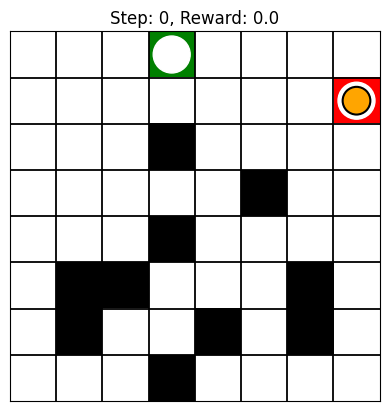

Location (0,7) t=0 reward=0.0
Location (0,6) t=1 reward=0.0
Location (1,6) t=2 reward=0.0
Location (2,6) t=3 reward=0.0
Location (2,5) t=4 reward=0.0
Location (2,6) t=5 reward=0.0
Location (3,6) t=6 reward=0.0
Location (2,6) t=7 reward=0.0
Location (3,6) t=8 reward=0.0
Location (3,6) t=9 reward=-1.0


In [ ]:
import gymnasium as gym
import gym_simplegrid

START_LOC = 15
GOAL_LOC = 3
# Define the initial location and the goal location in the grid.
# Each grid cell has an a number from 0 to 63.
options ={
    'start_loc': START_LOC,
    'goal_loc': GOAL_LOC
}

env = gym.make('SimpleGrid-8x8-v0', render_mode='human')
obs, info = env.reset(seed=1, options=options)
done = env.unwrapped.done

for t in range(10):
    if done:
        break
    action = env.action_space.sample()   # Random action
    obs, reward, done, _, info = env.step(action)

    grid_size = 8
    row = obs // grid_size
    col = obs % grid_size
    print("Location (", row, ",", col, ") t=",t, " reward=", reward, sep="")

# env.close()

In [18]:
# lab2_number3.py  — Monte Carlo value function on SimpleGrid-8x8-v0

import os
import numpy as np

# ----- plotting: always save a PNG even without GUI backend -----
import matplotlib
matplotlib.use("Agg")  # non-GUI backend (always can save files)
import matplotlib.pyplot as plt
import seaborn as sns

import gymnasium as gym
import gym_simplegrid  # pip install gym-simplegrid

import time


# -------------------- CONFIG --------------------
ENV_ID    = "SimpleGrid-8x8-v0"
GRID_N    = 8
START_LOC = 15
GOAL_LOC  = 3
OPTIONS   = {"start_loc": START_LOC, "goal_loc": GOAL_LOC}


EPISODES  = 50_000     # reduce for quick test, e.g., 5_000
GAMMA     = 1.0
SEED      = 42
MAX_STEPS = 200        # safety cap per episode
# ------------------------------------------------

def mc_value_function(env, options=None, gamma=1.0, episodes=50_000, seed=0, max_steps=1_000, verbose=True):
    """First-Visit Monte Carlo policy evaluation under a random policy."""
    rng = np.random.default_rng(seed)
    nS = env.observation_space.n
    nA = env.action_space.n

    returns_sum   = np.zeros(nS, dtype=float)
    returns_count = np.zeros(nS, dtype=int)
    V             = np.zeros(nS, dtype=float)

    for ep in range(int(episodes)):
        # --- generate one episode ---
        obs, info = env.reset(seed=int(rng.integers(0, 10_000)), options=options)
        s = int(obs)
        episode = []  # list of (s, a, r)
        terminated = truncated = False
        steps = 0

        while not (terminated or truncated) and steps < max_steps:
            a  = int(rng.integers(0, nA))              # equiprobable random action
            ns, r, terminated, truncated, info = env.step(a)
            episode.append((s, a, r))
            s = int(ns)
            steps += 1

        # --- First-Visit MC backup (backward return) ---
        G = 0.0
        visited = set()
        for t in reversed(range(len(episode))):
            s_t, a_t, r_t = episode[t]
            G = gamma * G + r_t
            if s_t not in visited:
                visited.add(s_t)
                returns_sum[s_t]   += G
                returns_count[s_t] += 1
                V[s_t] = returns_sum[s_t] / returns_count[s_t]

        if verbose and (ep + 1) % 5000 == 0:
            print(f"[MC] episode {ep+1}/{episodes}")

    return V

def plot_value_grid(V, n=GRID_N, title="MC Value Function (First-Visit, random policy)", out_path=None):
    """Save heatmap to out_path (PNG)."""
    grid = V.reshape(n, n)
    fig = plt.figure(figsize=(5,5))
    ax  = fig.add_subplot(111)
    sns.heatmap(grid, annot=True, cmap="viridis", fmt=".1f", linewidths=.5, cbar=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Column"); ax.set_ylabel("Row")
    fig.tight_layout()

    if out_path is None:
        out_path = os.path.abspath("mc_value_heatmap.png")
    fig.savefig(out_path, dpi=160)
    print(f"[plot] saved heatmap to: {out_path}")
    plt.close(fig)

if __name__ == "__main__":
    # 1) make env (no render for speed)
    env = gym.make(ENV_ID)

    # 2) run Monte Carlo
    V_mc = mc_value_function(
        env,
        options=OPTIONS,
        gamma=GAMMA,
        episodes=EPISODES,
        seed=SEED,
        max_steps=MAX_STEPS,
        verbose=True,
    )

    # 3) print values
    print("\nV (flat):\n", np.round(V_mc, 2))
    print("\nV (grid):\n", np.round(V_mc.reshape(GRID_N, GRID_N), 2))

    # 4) save CSV + heatmap PNG
    cwd     = os.path.abspath(os.getcwd())
    out_png = os.path.join(cwd, "mc_value_heatmap.png")
    out_csv = os.path.join(cwd, "mc_value_grid.csv")

    np.savetxt(out_csv, V_mc.reshape(GRID_N, GRID_N), delimiter=",", fmt="%.6f")
    print(f"[plot] saved raw grid to: {out_csv}")

    plot_value_grid(V_mc, n=GRID_N, out_path=out_png)
    print("\nOpen the saved image:\n", out_png)

def run_live_demo(steps=200, fps=8, seed=1):
    """랜덤 정책으로 1에피소드 재생(창이 뜸)."""
    env = gym.make(ENV_ID, render_mode="human")
    obs, info = env.reset(seed=seed, options=OPTIONS)
    terminated = truncated = False
    for t in range(steps):
        if terminated or truncated:
            break
        a = env.action_space.sample()
        obs, r, terminated, truncated, info = env.step(a)
        time.sleep(1.0 / fps)  # 너무 빨리 지나가지 않도록
    env.close()

run_live_demo(steps=200, fps=8, seed=1)

[MC] episode 5000/50000
[MC] episode 10000/50000
[MC] episode 15000/50000
[MC] episode 20000/50000
[MC] episode 25000/50000
[MC] episode 30000/50000
[MC] episode 35000/50000
[MC] episode 40000/50000
[MC] episode 45000/50000
[MC] episode 50000/50000

V (flat):
 [ -8.26  -7.01  -4.47   0.    -7.26 -12.21 -15.53 -18.13  -9.    -8.23
  -7.22  -6.11 -10.06 -12.97 -15.66 -18.55 -10.16  -9.79  -9.99   0.
 -14.2  -15.09 -16.27 -18.49 -11.45 -11.02 -11.9  -15.73 -16.12   0.
 -18.39 -18.8  -12.14 -12.15 -13.1    0.   -17.74 -18.18 -18.6  -18.76
 -13.57   0.     0.   -20.07 -18.6  -18.52   0.   -20.4  -14.5    0.
 -18.37 -19.41   0.   -19.42   0.   -20.58 -15.27 -16.06 -17.13   0.
 -21.48 -18.73 -19.7  -20.36]

V (grid):
 [[ -8.26  -7.01  -4.47   0.    -7.26 -12.21 -15.53 -18.13]
 [ -9.    -8.23  -7.22  -6.11 -10.06 -12.97 -15.66 -18.55]
 [-10.16  -9.79  -9.99   0.   -14.2  -15.09 -16.27 -18.49]
 [-11.45 -11.02 -11.9  -15.73 -16.12   0.   -18.39 -18.8 ]
 [-12.14 -12.15 -13.1    0.   -17.74 -18.18

SystemExit: 

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
